In [1]:
import numpy as np
import pandas as pd
import datetime
import pytz
from matplotlib import pyplot as plt
import matplotlib as mpl
import os
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_halving_search_cv # noqa
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from utils_segmentation import p3,p4
import hvplot.pandas
np.random.seed(42)
import pickle
import logging
logging.basicConfig(level=logging.INFO)

In [124]:
datestr = datetime.datetime.strftime(datetime.datetime.now(),'%Y%m%d')

In [125]:
inputs = ['Rg', 'Tair', 'VPD','elevation',
       'azimuth', 'fssun', 'fsshd', 'frsun', 'frshd', 'fvsun', 'fvshd',
       'fwsun', 'fwshd', 'Tssun', 'Tsshd', 'Trsun', 'Trshd', 'Tvsun', 'Tvshd',
       'Twsun', 'Twshd'] 

In [126]:
datestr = datetime.datetime.strftime(datetime.datetime.now(),'%Y%m%d')

In [ ]:
daily_flux_cook=pd.read_csv('Z:/usda/DataLake/work/CookIRCamET/Working/cook_et_batches_processed_all_20250105.csv')
daily_flux_cprl=pd.read_csv('Z:/usda/DataLake/work/CookIRCamET/Working/cprl_et_batches_processed_all_20250106.csv')

/project/nsaru/nsaru-cv/lib/python3.11/site-packages/pkg_resources/_vendor/pyparsing.py:87: DeprecationWarning: module 'sre_constants' is deprecated
  import sre_constants
/project/nsaru/nsaru-cv/lib/python3.11/site-packages/pkg_resources/_vendor/pyparsing.py:87: DeprecationWarning: module 'sre_constants' is deprecated
  import sre_constants
/project/nsaru/nsaru-cv/lib/python3.11/site-packages/pkg_resources/_vendor/pyparsing.py:87: DeprecationWarning: module 'sre_constants' is deprecated
  import sre_constants
/project/nsaru/nsaru-cv/lib/python3.11/site-packages/pkg_resources/_vendor/pyparsing.py:87: DeprecationWarning: module 'sre_constants' is deprecated
  import sre_constants
/project/nsaru/nsaru-cv/lib/python3.11/site-packages/pkg_resources/_vendor/pyparsing.py:87: DeprecationWarning: module 'sre_constants' is deprecated
  import sre_constants
/project/nsaru/nsaru-cv/lib/python3.11/site-packages/pkg_resources/_vendor/pyparsing.py:87: DeprecationWarning: module 'sre_constants' is de

Best parameter (CV score=0.747):
{'clf__activation': 'tanh', 'clf__hidden_layer_sizes': (24, 8, 2, 1)}
Best parameter (CV score=0.853):
{'clf__activation': 'logistic', 'clf__hidden_layer_sizes': (48, 13, 3, 2)}
Best parameter (CV score=0.877):
{'clf__activation': 'logistic', 'clf__hidden_layer_sizes': (72, 17, 4, 3)}
Best parameter (CV score=0.857):
{'clf__activation': 'logistic', 'clf__hidden_layer_sizes': (32, 10, 3, 4)}
Best parameter (CV score=0.869):
{'clf__activation': 'logistic', 'clf__hidden_layer_sizes': (144, 27, 5, 6)}


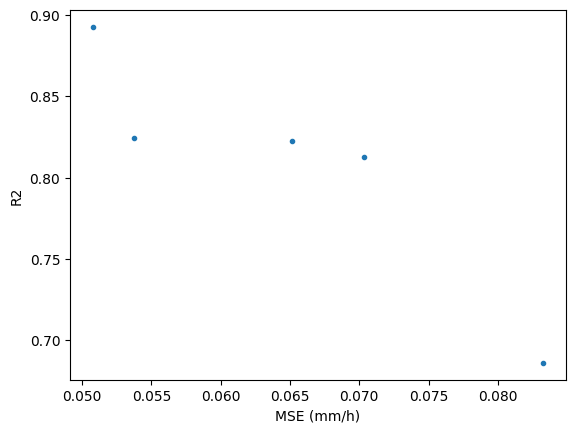

[[0.0832946454149599, 0.6861297274105276, 1, 1220, 12139], [0.06512080862299292, 0.8223183838305095, 2, 4786, 6069], [0.07034220780947288, 0.8127138568030983, 3, 10673, 4046], [0.05074914751466414, 0.8927012005852902, 4, 10349, 3034], [0.053755996238352255, 0.8242673872466988, 6, 42226, 2023]]


In [128]:
lab = 'all'

daily_flux = pd.concat([daily_flux_cook,daily_flux_cprl])

daily_flux.keys()

daily_flux['DeltaTsshd'] = (daily_flux.Tair-daily_flux.Tsshd)*daily_flux.fsshd
daily_flux['DeltaTssun'] = (daily_flux.Tair-daily_flux.Tssun)*daily_flux.fssun

daily_flux['DeltaTvshd'] = (daily_flux.Tair-daily_flux.Tvshd)*daily_flux.fvshd
daily_flux['DeltaTvsun'] = (daily_flux.Tair-daily_flux.Tvsun)*daily_flux.fvsun

daily_flux['DeltaTrshd'] = (daily_flux.Tair-daily_flux.Trshd)*daily_flux.frshd
daily_flux['DeltaTrsun'] = (daily_flux.Tair-daily_flux.Trsun)*daily_flux.frsun

daily_flux['DeltaTwshd'] = (daily_flux.Tair-daily_flux.Twshd)*daily_flux.fwshd
daily_flux['DeltaTwsun'] = (daily_flux.Tair-daily_flux.Twsun)*daily_flux.fwsun

daily_flux['DeltaVsshd'] = (daily_flux.VPD)*daily_flux.fsshd
daily_flux['DeltaVssun'] = (daily_flux.VPD)*daily_flux.fssun

daily_flux['DeltaVvshd'] = (daily_flux.VPD)*daily_flux.fvshd
daily_flux['DeltaVvsun'] = (daily_flux.VPD)*daily_flux.fvsun

daily_flux['DeltaVrshd'] = (daily_flux.VPD)*daily_flux.frshd
daily_flux['DeltaVrsun'] = (daily_flux.VPD)*daily_flux.frsun

daily_flux['DeltaVwshd'] = (daily_flux.VPD)*daily_flux.fwshd
daily_flux['DeltaVwsun'] = (daily_flux.VPD)*daily_flux.fwsun

daily_flux['Rsshd'] = (daily_flux.Rg)*daily_flux.fsshd
daily_flux['Rssun'] = (daily_flux.Rg)*daily_flux.fssun

daily_flux['Rvshd'] = (daily_flux.Rg)*daily_flux.fvshd
daily_flux['Rvsun'] = (daily_flux.Rg)*daily_flux.fvsun

daily_flux['Rrshd'] = (daily_flux.Rg)*daily_flux.frshd
daily_flux['Rrsun'] = (daily_flux.Rg)*daily_flux.frsun

daily_flux['Rwshd'] = (daily_flux.Rg)*daily_flux.fwshd
daily_flux['Rwsun'] = (daily_flux.Rg)*daily_flux.fwsun

inputs = daily_flux.keys()[-24:]

n_feats = len(inputs)
best_scores = []
for period_length in [1,2,3,4,6]:
    batched_flux = daily_flux[[*inputs]].values.reshape([-1,period_length*n_feats])
    batched_et = daily_flux[['ET']].values.reshape([-1,period_length])
    n_batches = batched_flux.shape[0]
    n_train = int(0.9*n_batches)
    n_test = n_batches-n_train
    batches = np.arange(n_batches)
    np.random.shuffle(batches)
    train = batches[0:n_train]
    test = batches[n_train:]
    batches_train_et,batches_train_feats = np.sum(batched_et[train,:],axis=1),batched_flux[train,0:period_length*n_feats] 
    batches_test_et,batches_test_feats =  np.sum(batched_et[test,:],axis=1),batched_flux[test,0:period_length*n_feats] 
    batches_train_et.shape
    
    #Pipeline
    #initial scaling
    scaler = StandardScaler()
    clf = MLPRegressor(max_iter=10000)
    #tune hyperparameters
    layers = []
    
    for layer1 in [1,3,7,21]:
        for layer2 in [1,3,6,18]:
            layer = (n_feats*period_length//layer1,int((n_feats*period_length//(layer2*layer1))**(2/3)),int((n_feats*period_length//(layer2*layer1))**(1/3)),period_length//layer2)
            layers.append(layer)
    
    parameters = {'clf__hidden_layer_sizes':layers,'clf__activation':['tanh','relu','logistic','linear']}
    pipeline = Pipeline(steps=[("scaler", scaler), ("clf", clf)])#
    
    search = GridSearchCV(pipeline, parameters,n_jobs=-1,cv=10,verbose=0)
    
    search.fit(batches_train_feats, batches_train_et)
    print("Best parameter (CV score=%0.3f):" % search.best_score_)
    print(search.best_params_)
    filename = os.path.join(p3,'et_mlp_pipeline_'+lab+'_'+str(period_length)+'_final.pk.sav')
    with open(filename, 'wb') as f:  # Python 3: open(..., 'wb'
        pickle.dump(search.best_estimator_, f)
    pred = search.predict(batches_test_feats)
    mlp = search.best_estimator_['clf']

    n_param = 0
    for i in range(4):
        n_param+=mlp.coefs_[i].shape[0]*mlp.coefs_[i].shape[0]
    
    best_scores.append([np.sqrt(mean_squared_error(pred,batches_test_et))/period_length,
                        r2_score(pred,batches_test_et),period_length,n_param,n_train])
    plt.plot(batches_test_et,pred,'.')
    plt.title(str(period_length))
    plt.ylabel('Predicted ET (mm)')
    plt.xlabel('Actual ET (mm)')
    filename = os.path.join(p4,'test_set_'+lab+'_'+str(period_length)+'_final.png')
    plt.savefig(filename,dpi=300)
    plt.clf()
    
plt.plot(np.array(best_scores)[:,0],np.array(best_scores)[:,1],'.')
plt.ylabel('R2')
plt.xlabel('MSE (mm/h)')
plt.show()

pd.DataFrame(np.array(best_scores),columns=['MSE (mm/h)','R2','Period','n_params','n_train']).to_csv(p3+'/'+'mlp_results_'+lab+'_'+datestr+'.csv')

print(best_scores)

In [129]:
filename = os.path.join(p3,'et_mlp_pipeline_all_2_final.pk.sav')
with open(filename, 'rb') as f:  # Python 3: open(..., 'wb'
    model = pickle.load(f)

In [142]:
X = daily_flux[inputs].values.reshape([-1,2*n_feats])
ET = np.sum(daily_flux['ET'].values.reshape([-1,2]),axis=1)/2
times = pd.to_datetime(daily_flux['times']).values.reshape([-1,2])[:,1]
ET_ = model.predict(X)/2
nrow_cook = len(daily_flux_cook)/2
df = pd.DataFrame({'times':times,'ETobserved':ET,'ETpredicted':ET_})
df['Site'] = 'CPRL'
df.loc[0:nrow_cook-1,'Site'] = 'NSAR'
(df[df.Site=='NSAR'].hvplot.scatter(x='times',y=['ETpredicted','ETobserved']).options(xlabel='Time (UTC)', ylabel='ET (mm/h)').relabel('NSAR')+df[df.Site=='CPRL'].hvplot.scatter(x='times',y=['ETpredicted','ETobserved']).options(xlabel='Time (UTC)', ylabel='ET (mm/h)').relabel('CPRL')).cols(1)

:Layout
   .NdOverlay.NSAR :NdOverlay   [Variable]
      :Scatter   [times]   (value)
   .NdOverlay.CPRL :NdOverlay   [Variable]
      :Scatter   [times]   (value)

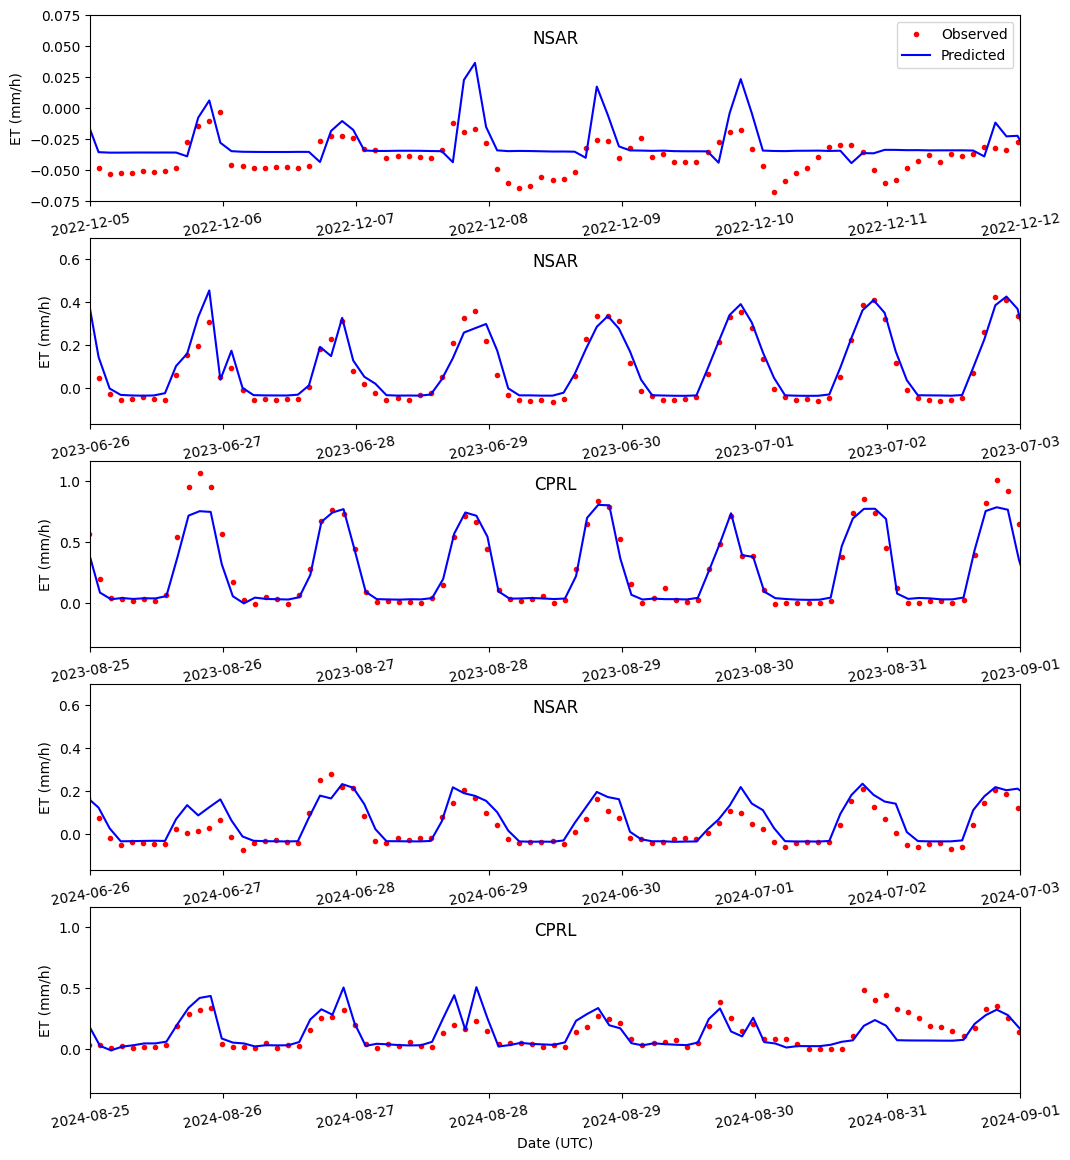

In [167]:
fig,axs = plt.subplots(nrows=5,ncols=1,figsize=(12, 14))
axs[0].plot(df[df.Site=='NSAR'].times,df[df.Site=='NSAR'].ETobserved,'r.',label='Observed')
axs[0].plot(df[df.Site=='NSAR'].times,df[df.Site=='NSAR'].ETpredicted,'b-',label='Predicted')
axs[0].set_ylabel('ET (mm/h)')
axs[0].set_ylim([-.075,0.075])
axs[0].set_xlim([pd.to_datetime('2022-12-05'),pd.to_datetime('2022-12-12')])
axs[0].tick_params(axis='x', labelrotation=10)
axs[0].set_title('NSAR',y=0.8)
axs[0].legend()

axs[1].plot(df[df.Site=='NSAR'].times,df[df.Site=='NSAR'].ETobserved,'r.',label='Observed')
axs[1].plot(df[df.Site=='NSAR'].times,df[df.Site=='NSAR'].ETpredicted,'b-',label='Predicted')
axs[1].set_ylabel('ET (mm/h)')
axs[1].set_xlim([pd.to_datetime('2023-06-26'),pd.to_datetime('2023-07-03')])
axs[1].tick_params(axis='x', labelrotation=10)
axs[1].set_title('NSAR',y=0.8)

axs[2].plot(df[df.Site=='CPRL'].times,df[df.Site=='CPRL'].ETobserved,'r.')
axs[2].plot(df[df.Site=='CPRL'].times,df[df.Site=='CPRL'].ETpredicted,'b-')
axs[2].set_title('CPRL',y=0.8)
axs[2].set_ylabel('ET (mm/h)')
axs[2].tick_params(axis='x', labelrotation=10)
axs[2].set_xlim([pd.to_datetime('2023-08-25'),pd.to_datetime('2023-09-01')])

axs[3].plot(df[df.Site=='NSAR'].times,df[df.Site=='NSAR'].ETobserved,'r.',label='Observed')
axs[3].plot(df[df.Site=='NSAR'].times,df[df.Site=='NSAR'].ETpredicted,'b-',label='Predicted')
axs[3].set_ylabel('ET (mm/h)')
axs[3].set_xlim([pd.to_datetime('2024-06-26'),pd.to_datetime('2024-07-03')])
axs[3].tick_params(axis='x', labelrotation=10)
axs[3].set_title('NSAR',y=0.8)

axs[4].plot(df[df.Site=='CPRL'].times,df[df.Site=='CPRL'].ETobserved,'r.')
axs[4].plot(df[df.Site=='CPRL'].times,df[df.Site=='CPRL'].ETpredicted,'b-')
axs[4].set_title('CPRL',y=0.8)
axs[4].set_ylabel('ET (mm/h)')
axs[4].set_xlabel('Date (UTC)')
axs[4].tick_params(axis='x', labelrotation=10)
axs[4].set_xlim([pd.to_datetime('2024-08-25'),pd.to_datetime('2024-09-01')])
filename = os.path.join(p4,'timeseries_'+lab+'_2_final.png')
fig.savefig(filename,dpi=300)

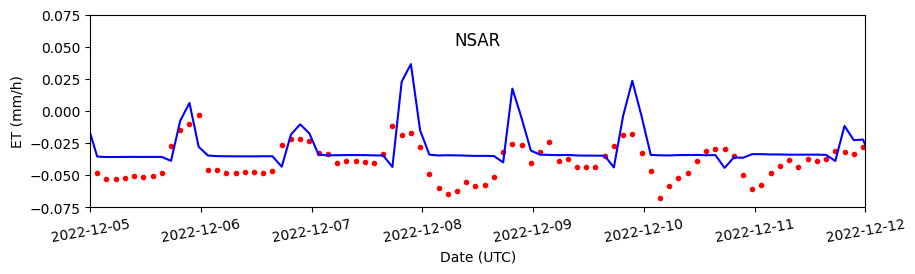

In [147]:
df[df.Site=='CPRL'].ETobserved.sum()-df[df.Site=='CPRL'].ETpredicted.sum()

14.749491922851917

In [148]:
df[df.Site=='NSAR'].ETobserved.sum()-df[df.Site=='NSAR'].ETpredicted.sum()

-18.60621521148228

In [141]:
nrow_cook


4380.0

In [ ]:
daily_flux_cook=pd.read_csv('/90daydata/nsaru/work/CookIRCamET/Working/cook_et_batches_processed_20250102.csv')
#daily_flux_cook_24=pd.read_csv('../../work/CookIRCamET/Working/cookhy2024_batches_processed.csv')
daily_flux_cprl=pd.read_csv('/90daydata/nsaru/work/CookIRCamET/Working/cprl_et_batches_processed_20241231.csv')
#daily_flux_cook=pd.concat([daily_flux_cook_23,daily_flux_cook_24])

/project/nsaru/nsaru-cv/lib/python3.11/site-packages/pkg_resources/_vendor/pyparsing.py:87: DeprecationWarning: module 'sre_constants' is deprecated
  import sre_constants
/project/nsaru/nsaru-cv/lib/python3.11/site-packages/pkg_resources/_vendor/pyparsing.py:87: DeprecationWarning: module 'sre_constants' is deprecated
  import sre_constants
/project/nsaru/nsaru-cv/lib/python3.11/site-packages/pkg_resources/_vendor/pyparsing.py:87: DeprecationWarning: module 'sre_constants' is deprecated
  import sre_constants
/project/nsaru/nsaru-cv/lib/python3.11/site-packages/pkg_resources/_vendor/pyparsing.py:87: DeprecationWarning: module 'sre_constants' is deprecated
  import sre_constants
/project/nsaru/nsaru-cv/lib/python3.11/site-packages/pkg_resources/_vendor/pyparsing.py:87: DeprecationWarning: module 'sre_constants' is deprecated
  import sre_constants
/project/nsaru/nsaru-cv/lib/python3.11/site-packages/pkg_resources/_vendor/pyparsing.py:87: DeprecationWarning: module 'sre_constants' is de

Best parameter (CV score=0.828):
{'clf__activation': 'tanh', 'clf__hidden_layer_sizes': (24, 8, 2, 1)}


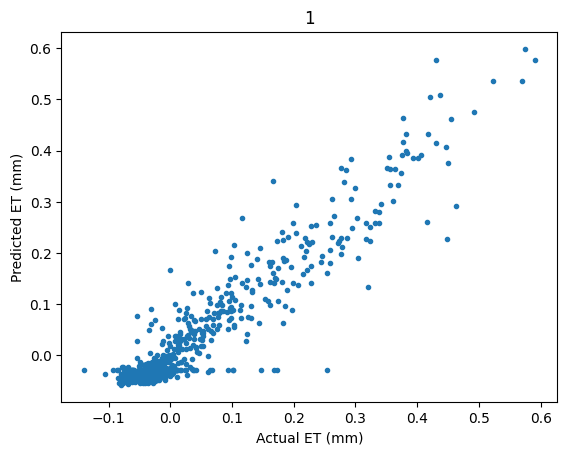

Best parameter (CV score=0.876):
{'clf__activation': 'tanh', 'clf__hidden_layer_sizes': (48, 13, 3, 2)}


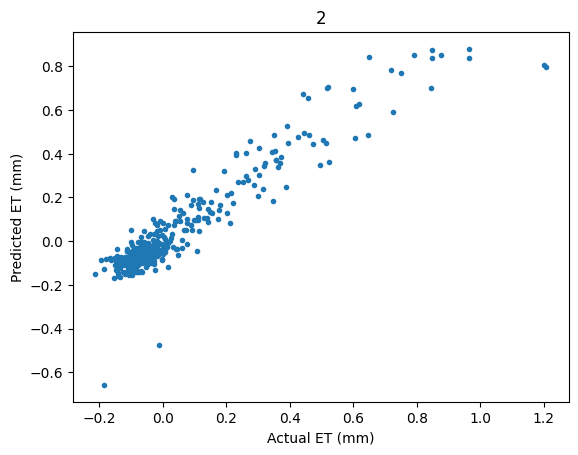

Best parameter (CV score=0.907):
{'clf__activation': 'tanh', 'clf__hidden_layer_sizes': (72, 17, 4, 3)}


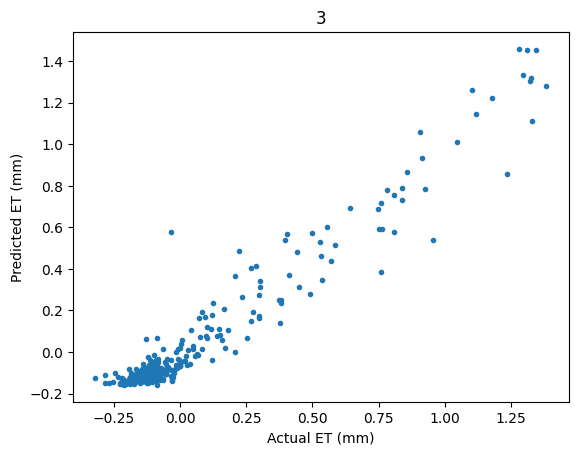

Best parameter (CV score=0.910):
{'clf__activation': 'logistic', 'clf__hidden_layer_sizes': (96, 20, 4, 4)}


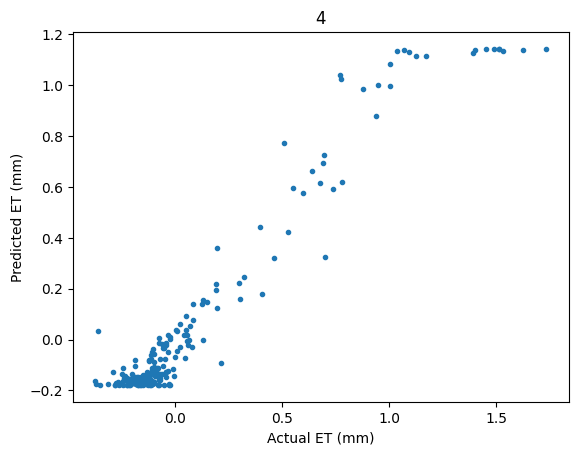

Best parameter (CV score=0.919):
{'clf__activation': 'logistic', 'clf__hidden_layer_sizes': (144, 27, 5, 6)}


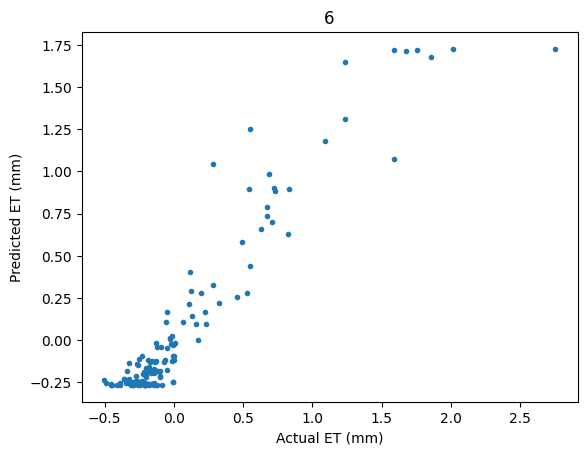

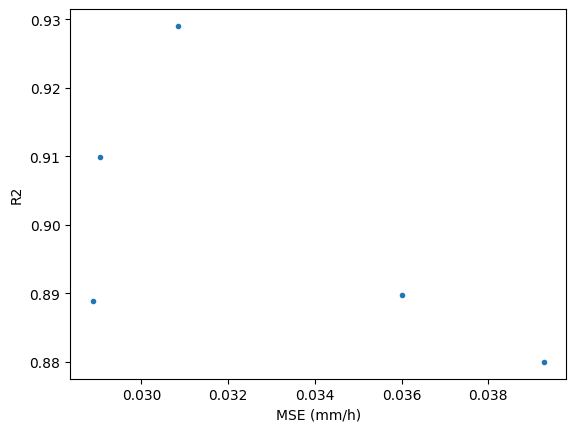

[[0.03927767707862103, 0.879992541094256, 1, 1220, 7884], [0.03600718116840713, 0.8897729129632467, 2, 4786, 3942], [0.030850627188265794, 0.9290182620982502, 3, 10673, 2628], [0.029045031411471946, 0.9098427171759877, 4, 18848, 1971], [0.028875694026990584, 0.8889112921286283, 6, 42226, 1314]]
Best parameter (CV score=0.744):
{'clf__activation': 'tanh', 'clf__hidden_layer_sizes': (24, 8, 2, 1)}


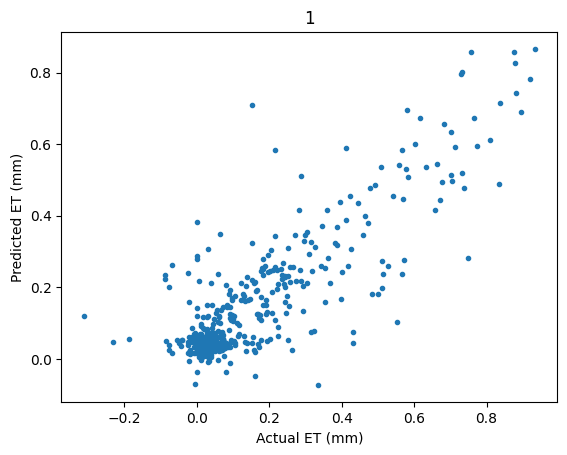

Best parameter (CV score=0.785):
{'clf__activation': 'tanh', 'clf__hidden_layer_sizes': (48, 13, 3, 2)}


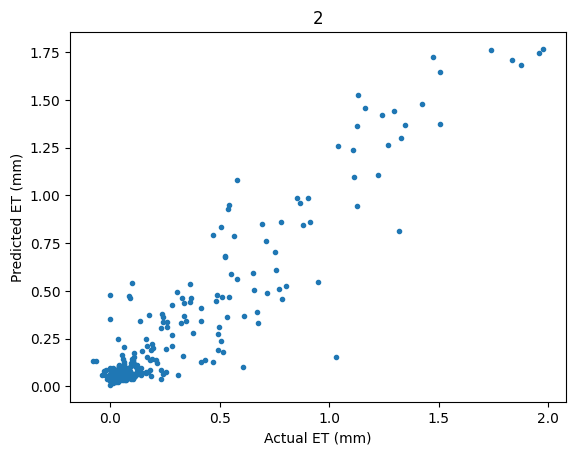

Best parameter (CV score=0.796):
{'clf__activation': 'logistic', 'clf__hidden_layer_sizes': (72, 17, 4, 3)}


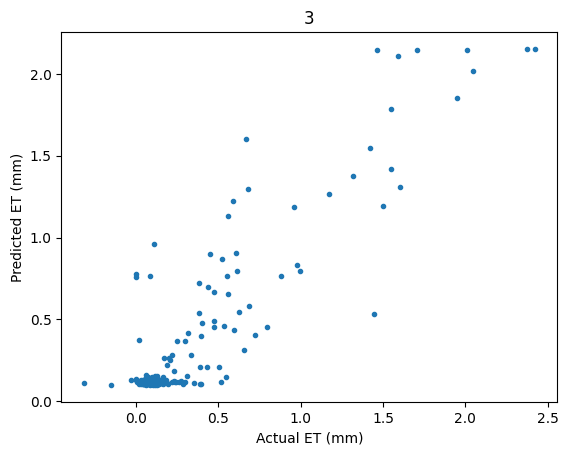

Best parameter (CV score=0.807):
{'clf__activation': 'logistic', 'clf__hidden_layer_sizes': (32, 10, 3, 4)}


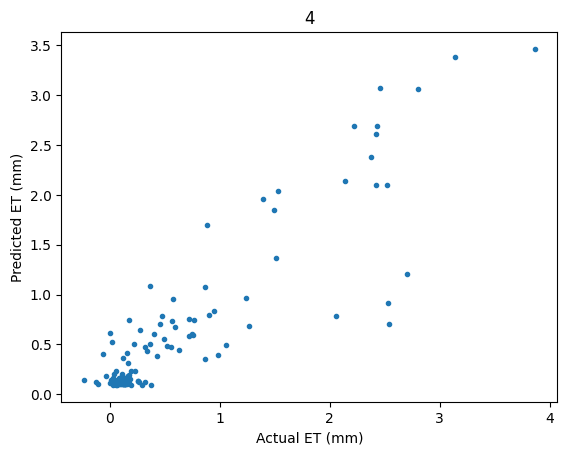

Best parameter (CV score=0.745):
{'clf__activation': 'tanh', 'clf__hidden_layer_sizes': (6, 3, 1, 6)}


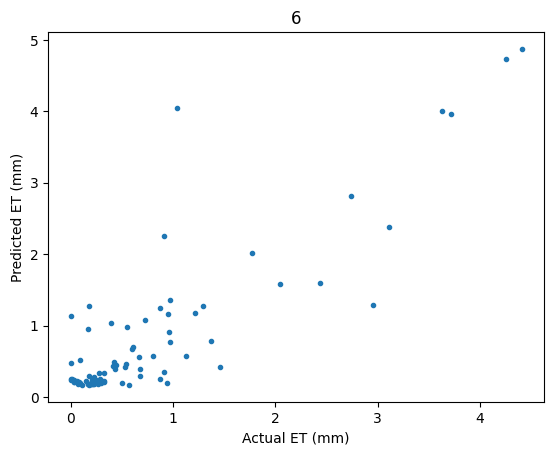

In [ ]:
for lab,daily_flux in zip(['cook','cprl'],[daily_flux_cook,daily_flux_cprl]):
    
    daily_flux.keys()
    
    daily_flux['DeltaTsshd'] = (daily_flux.Tair-daily_flux.Tsshd)*daily_flux.fsshd
    daily_flux['DeltaTssun'] = (daily_flux.Tair-daily_flux.Tssun)*daily_flux.fssun
    
    daily_flux['DeltaTvshd'] = (daily_flux.Tair-daily_flux.Tvshd)*daily_flux.fvshd
    daily_flux['DeltaTvsun'] = (daily_flux.Tair-daily_flux.Tvsun)*daily_flux.fvsun
    
    daily_flux['DeltaTrshd'] = (daily_flux.Tair-daily_flux.Trshd)*daily_flux.frshd
    daily_flux['DeltaTrsun'] = (daily_flux.Tair-daily_flux.Trsun)*daily_flux.frsun
    
    daily_flux['DeltaTwshd'] = (daily_flux.Tair-daily_flux.Twshd)*daily_flux.fwshd
    daily_flux['DeltaTwsun'] = (daily_flux.Tair-daily_flux.Twsun)*daily_flux.fwsun
    
    daily_flux['DeltaVsshd'] = (daily_flux.VPD)*daily_flux.fsshd
    daily_flux['DeltaVssun'] = (daily_flux.VPD)*daily_flux.fssun
    
    daily_flux['DeltaVvshd'] = (daily_flux.VPD)*daily_flux.fvshd
    daily_flux['DeltaVvsun'] = (daily_flux.VPD)*daily_flux.fvsun
    
    daily_flux['DeltaVrshd'] = (daily_flux.VPD)*daily_flux.frshd
    daily_flux['DeltaVrsun'] = (daily_flux.VPD)*daily_flux.frsun
    
    daily_flux['DeltaVwshd'] = (daily_flux.VPD)*daily_flux.fwshd
    daily_flux['DeltaVwsun'] = (daily_flux.VPD)*daily_flux.fwsun
    
    daily_flux['Rsshd'] = (daily_flux.Rg)*daily_flux.fsshd
    daily_flux['Rssun'] = (daily_flux.Rg)*daily_flux.fssun
    
    daily_flux['Rvshd'] = (daily_flux.Rg)*daily_flux.fvshd
    daily_flux['Rvsun'] = (daily_flux.Rg)*daily_flux.fvsun
    
    daily_flux['Rrshd'] = (daily_flux.Rg)*daily_flux.frshd
    daily_flux['Rrsun'] = (daily_flux.Rg)*daily_flux.frsun
    
    daily_flux['Rwshd'] = (daily_flux.Rg)*daily_flux.fwshd
    daily_flux['Rwsun'] = (daily_flux.Rg)*daily_flux.fwsun
    
    inputs = daily_flux.keys()[-24:]
    
    n_feats = len(inputs)
    best_scores = []
    for period_length in [1,2,3,4,6]:
        batched_flux = daily_flux[[*inputs]].values.reshape([-1,period_length*n_feats])
        batched_et = daily_flux[['ET']].values.reshape([-1,period_length])
        n_batches = batched_flux.shape[0]
        n_train = int(0.9*n_batches)
        n_test = n_batches-n_train
        batches = np.arange(n_batches)
        np.random.shuffle(batches)
        train = batches[0:n_train]
        test = batches[n_train:]
        batches_train_et,batches_train_feats = np.sum(batched_et[train,:],axis=1),batched_flux[train,0:period_length*n_feats] 
        batches_test_et,batches_test_feats =  np.sum(batched_et[test,:],axis=1),batched_flux[test,0:period_length*n_feats] 
        batches_train_et.shape
        
        #Pipeline
        #initial scaling
        scaler = StandardScaler()
        clf = MLPRegressor(max_iter=10000)
        #tune hyperparameters
        layers = []
        
        for layer1 in [1,3,7,21]:
            for layer2 in [1,3,6,18]:
                layer = (n_feats*period_length//layer1,int((n_feats*period_length//(layer2*layer1))**(2/3)),int((n_feats*period_length//(layer2*layer1))**(1/3)),period_length//layer2)
                layers.append(layer)
        
        parameters = {'clf__hidden_layer_sizes':layers,'clf__activation':['tanh','relu','logistic','linear']}
        pipeline = Pipeline(steps=[("scaler", scaler), ("clf", clf)])#
        
        search = GridSearchCV(pipeline, parameters,n_jobs=-1,cv=10,verbose=0)
        
        search.fit(batches_train_feats, batches_train_et)
        print("Best parameter (CV score=%0.3f):" % search.best_score_)
        print(search.best_params_)
        filename = os.path.join(p3,'et_mlp_pipeline_'+lab+'_'+str(period_length)+'_final.pk.sav')
        with open(filename, 'wb') as f:  # Python 3: open(..., 'wb'
            pickle.dump(search.best_estimator_, f)
        pred = search.predict(batches_test_feats)
        mlp = search.best_estimator_['clf']
    
        n_param = 0
        for i in range(4):
            n_param+=mlp.coefs_[i].shape[0]*mlp.coefs_[i].shape[0]
        
        best_scores.append([np.sqrt(mean_squared_error(pred,batches_test_et))/period_length,
                            r2_score(pred,batches_test_et),period_length,n_param,n_train])
        plt.plot(batches_test_et,pred,'.')
        plt.title(str(period_length))
        plt.ylabel('Predicted ET (mm)')
        plt.xlabel('Actual ET (mm)')
        plt.show()
    
    plt.plot(np.array(best_scores)[:,0],np.array(best_scores)[:,1],'.')
    plt.ylabel('R2')
    plt.xlabel('MSE (mm/h)')
    plt.show()
    
    pd.DataFrame(np.array(best_scores),columns=['MSE (mm/h)','R2','Period','n_params','n_train']).to_csv(p3+'/'+'mlp_results_'+lab+'_'+datestr+'.csv')
    
    print(best_scores)